In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

In [2]:
import utils as ut
early_stopping = ut.EarlyStopping(patience=100, verbose=1)

# 1. Create Data for Toy Problem

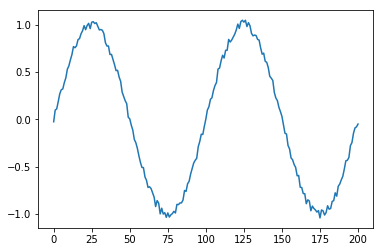

In [3]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T)
plt.plot(f)

# 2a. Prepare Input Data to Train the Model

In [4]:
length_of_sequences = 2*T
maxlen = 25
data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# 2b. Split Data into Training and Valdiation Set 

In [5]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=N_validation)

In [6]:
def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.Variable(initial, name=name)
    
def bias_variable(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

In [7]:
def inference_Manual(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    # define all our variables
    V = weight_variable([n_hidden, n_out])
    U = weight_variable([n_in, n_hidden]) # going to combine this as (x, U)
    W = weight_variable([n_hidden, n_hidden])
    b = bias_variable([n_hidden])
    c = bias_variable([n_out])
    
    with tf.variable_scope('RNN'):
        hlist = []
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
            h_i = tf.tanh(tf.matmul(x[:, t, :], U) + tf.matmul(h_prev, W) + b)
            hlist.append(h_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y, [V, U, W, c, b]

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse


In [ ]:
n_hidden = 20
batch_size = 10
n_in = 1
n_out = 1
hidden_vars = [] # This is the list of hidden vars, i.e. [h(t)]_{t \in [0, 25]}
init_state = tf.zeros((batch_size, n_hidden), dtype=tf.float32)


In [ ]:
tf.Variable(3)

In [ ]:
tf.reset_default_graph()

V = weight_variable([n_hidden, n_out], 'V')
U = weight_variable([n_in, n_hidden], 'U') # going to combine this as (x, U)
W = weight_variable([n_hidden, n_hidden], 'W')
b = bias_variable([n_hidden], 'b')
c = bias_variable([n_out], 'c')
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])


In [ ]:
with tf.variable_scope('RNN'):
    hlist = []
    h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
    for i in range(maxlen):
        if i > 0:
            tf.get_variable_scope().reuse_variables()
            h_prev = hlist[-1]
        h_i = tf.tanh(tf.matmul(x[:, i, :], U) + tf.matmul(h_prev, W) + b)
        hlist.append(h_i)
h_last = hlist[-1]
y = tf.matmul(h_last, V) + c

In [8]:

def loss_manual(x, t, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    U = weight_variable([n_in, n_hidden], 'U') # going to combine this as (x, U)
    W = weight_variable([n_hidden, n_hidden], 'W')
    b = bias_variable([n_hidden], 'b')
    c = bias_variable([n_out], 'c')
    
    
    with tf.variable_scope('RNN'):
        hlist = []
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
            h_i = tf.tanh(tf.matmul(x[:, i, :], U) + tf.matmul(h_prev, W) + b)
            hlist.append(h_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

In [9]:
tf.reset_default_graph()

maxlen = 25
n_hidden = 20
n_out = 1
n_in = 1

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
loss = loss_manual(x, t, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out,
               n_in=n_in)
train_step = training(loss)

In [ ]:
mse = tf.reduce_mean(tf.square(y - t))
optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
train_step = optimize.minimize(mse)


# 5. Run Computational Graph (with batches)

In [ ]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

In [ ]:
train_step

### Check if you can see these in the global variables collection

In [ ]:
#tf.reset_default_graph()
collections=[tf.GraphKeys.GLOBAL_VARIABLES]
tf.get_collection(collections[0])

In [ ]:
y

In [ ]:
collections=[tf.GraphKeys.GLOBAL_VARIABLES]
tf.get_collection(collections[0])

In [ ]:
collections

In [ ]:
a = tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3])
b = tf.constant([7, 8, 9, 10, 11, 12], shape=[3, 2])
print(a.shape)
print(b.shape)
tf.matmul(a,b)

In [ ]:
tf.zeros([1, 300])

In [ ]:
x = tf.placeholder(tf.float32, shape=[n_batches, maxlen, n_in])

# 3. Define Functions for Model

In [ ]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y, cell.variables

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

# 4. Define TF Graph

#### What happened to the variables in RNN cell?

In [ ]:
    W = cvars[0].eval(session=sess)
    bias = cvars[1].eval(session=sess)
    print(W.shape) # Note that the first part is from the input x, the second part
                   # From the hidden state
    print(bias.shape)

# Computational Graph without Batches

In [ ]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    sess.run(train_step, feed_dict={
        x: X_[start:end],
        t: Y_[start:end],
        n_batch: N_train
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stoapping
    if early_bstopping.validate(val_loss):
        break

In [ ]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

In [ ]:
(cell_output, state) = cell(x[:, 0, :], state)

In [ ]:
X.shape

In [ ]:
with tf.variable_scope('RNN'):
    for t in range(maxlen):
        

In [ ]:
# For simplicty reasons, let us first implement a function that only has 2 lags
U = weight_variable([1, 1])
W = weight_variable([1, ])

h2 = tf.tanh(U)
V = weight_variable([n_hidden, 1])
c = bias_variable(1)
y = tf.matmul(h2, V) + c